In [87]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import argparse
import json

In [88]:
path = os.path.expanduser('~/MyMACS2/data/ATAC/RG_aligns/data_GSE')
name = 'GSM7790861'

db_top100_cells = pd.read_csv(f'{path}/{name}_top_100_rg_coordinates_of_reads.csv')
db_top100_cells.columns = ['RN', 'chr', 'x', 'y', 'RG', 'strand1', 'strand2']
db_top100_cells = db_top100_cells[['RG', 'chr', 'x', 'y']]
db_top100_cells.head()

,RG,chr,x,y
0,RG:Z:GGCTTCTACCGGTACC,chr1,9997,10392
1,RG:Z:GGCTTCTACCGGTACC,chr1,9997,10215
2,RG:Z:CGCTTAAGAAGAGGCT,chr1,9997,10411
3,RG:Z:AGGCGATGAAGAGGCT,chr1,10004,10083
4,RG:Z:AACCAACACGAGCCTC,chr1,10004,10083


In [89]:
import pandas as pd
import numpy as np

# Фиксация seed для воспроизводимости
np.random.seed(42)

# Параметры
rg = 'RG:Z:AAACCCTGAGTTCTCC'
threshold = 0.4  
N = 20           
x_min = 64470145   
y_max = 64472144   
chrs = ['chr1']

blurred_data_list = []

db_top100_cells = db_top100_cells[db_top100_cells['RG'] == rg]

for i in range(N):
    blurred_data = pd.DataFrame()

    for chrom in chrs:
        chr_data = db_top100_cells[db_top100_cells['chr'] == chrom]
        
        # Оставляем только риды, которые находятся в диапазоне [x_min, y_max]
        chr_data_filtered = chr_data[(chr_data['y'] >= x_min) & (chr_data['x'] <= y_max)]
        
        # Проверяем, что после фильтрации остались данные
        if not chr_data_filtered.empty:
            # Случайным образом выбираем threshold % ридов
            sampled_data = chr_data_filtered.sample(frac=threshold, random_state=i)
            # Добавляем в размытые данные
            blurred_data = pd.concat([blurred_data, sampled_data], ignore_index=True)

    # Добавляем размытые данные в список
    blurred_data_list.append(blurred_data)

# Пример: доступ к размытым данным для первой итерации
blurred_data_example = blurred_data_list[0]


In [90]:
blurred_data_example .head()

,RG,chr,x,y
0,RG:Z:AAACCCTGAGTTCTCC,chr1,64470145,64470418
1,RG:Z:AAACCCTGAGTTCTCC,chr1,64471408,64471484
2,RG:Z:AAACCCTGAGTTCTCC,chr1,64470928,64471123
3,RG:Z:AAACCCTGAGTTCTCC,chr1,64471115,64471321
4,RG:Z:AAACCCTGAGTTCTCC,chr1,64470534,64470730


In [91]:
def count_intensity(data):
    
    max_y = max(data['y']) + 1
    start_end_count_in_chr = np.zeros((max_y, 2), dtype=int)

    # Фильтрация и расчёт длины
    #data['length'] = data['y'] - data['x']

    # Заполнение интенсивности
    for _, row in data[['x', 'y']].iterrows():
        x = row['x']
        y = row['y']
        start_end_count_in_chr[x, 0] += 1
        start_end_count_in_chr[y, 1] += 1

    # Накопительная сумма интенсивности
    intensity_nucleotides = np.cumsum(start_end_count_in_chr[:, 0] - np.pad(start_end_count_in_chr[:, 1][1:], (1, 0), 'constant'))

    return intensity_nucleotides.tolist()




In [92]:
intensity_data = count_intensity(chr_data_filtered)
intensity_data = intensity_data[x_min : y_max + 1]

In [93]:
blured_intensity = count_intensity(blurred_data_list[1])

blured_intensity = blured_intensity[x_min : y_max + 1]
blured_intensity += [0] * (2000 - len(blured_intensity))

In [94]:
len(blured_intensity)

2000

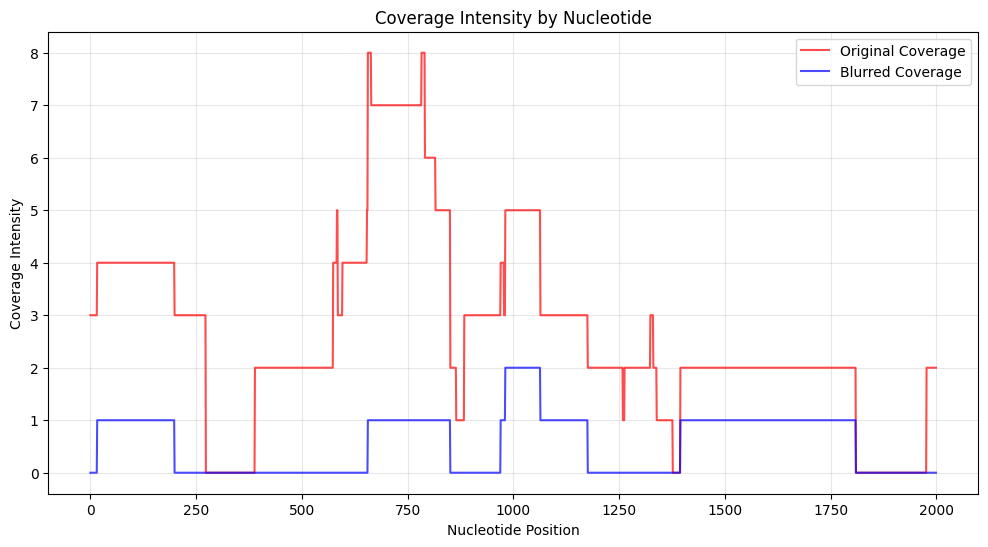

In [82]:
import matplotlib.pyplot as plt

def plot_intensity(original_intensity, blurred_intensity):
    """
    Функция для визуализации покрытий оригинальных и зашумленных данных.
    
    :param original_intensity: Интенсивность покрытия оригинальных данных.
    :param blurred_intensity: Интенсивность покрытия зашумленных данных.
    :param x_min: Начало отрезка (минимальный нуклеотид).
    :param x_max: Конец отрезка (максимальный нуклеотид).
    """
    positions = range(2000)

    plt.figure(figsize=(12, 6))

    # Оригинальное покрытие - красным
    plt.plot(positions, original_intensity, label="Original Coverage", color="red", alpha=0.7)

    # Зашумленное покрытие - синим
    plt.plot(positions, blurred_intensity, label="Blurred Coverage", color="blue", alpha=0.7)

    plt.title("Coverage Intensity by Nucleotide")
    plt.xlabel("Nucleotide Position")
    plt.ylabel("Coverage Intensity")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Параметры
x_min = 64470145
x_max = 64472144

# Визуализация покрытий
plot_intensity(intensity_data, blured_intensity)


In [27]:
sum(coverage_filtered)

np.int64(79072)